# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "[Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value](https://proceedings.mlr.press/v202/kwon23e.html)" ICML 2023 , using pyDVL.


The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

from concurrent.futures import FIRST_COMPLETED, wait
from typing import Literal

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
from support.common import load_adult_data

matplotlib.rcParams["axes.facecolor"] = (1, 1, 1, 0)

In [2]:
from pydvl.parallel import init_executor
from pydvl.reporting.plots import plot_values_ci, shaded_mean_std
from pydvl.reporting.scores import compute_removal_score
from pydvl.utils import Dataset, Scorer, Utility
from pydvl.value import ValuationResult, compute_data_oob

We will work with the [adult classification dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data) from the UCI repository. The objective is to predict whether a person earns more than 50k a year based on a set of features such as age, education, occupation, etc.

With a helper function we download the data and obtain the following pandas dataframe, where the categorical features have been removed:

In [3]:
data_adult = load_adult_data()
data_adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
0,39,77516,13,2174,0,40,<=50K
1,50,83311,13,0,0,13,<=50K
2,38,215646,9,0,0,40,<=50K
3,53,234721,7,0,0,40,<=50K
4,28,338409,13,0,0,40,<=50K


## Computing the OOB values

The main idea of Data-OOB is to take a pre-trained classifier and compute a per-sample out-of-bag performance estimate via bagging.

We use a simple KNN classifier with $k=5$ neighbours on the data and compute the data-oob values with three choices for the number of estimators in the bagging.
 
For that we construct a [Utility][pydvl.utils.utility.Utility] object using the [Scorer][pydvl.utils.score.Scorer] class to specify the metric to use for the evaluation. We then use the [compute_data_oob][pydvl.value.oob.compute_data_oob] function to compute the data-oob values:

In [4]:
data = Dataset.from_arrays(
    X=data_adult.drop(columns=["income"]).values,
    y=data_adult.loc[:, "income"].cat.codes.values,
)

model = KNeighborsClassifier(n_neighbors=5)

utility = Utility(model, data, Scorer("accuracy", default=0.0))

In [5]:
n_estimators = [100, 500]
oob_values = [
    compute_data_oob(utility, n_est=n_est, max_samples=0.95) for n_est in n_estimators
]

The two results are stored in an array of [ValuationResult][pydvl.value.result.ValuationResult] objects. Here's their distribution. The left-hand side depicts value as it increases with rank and a 99% t-confidence interval. The right-hand side shows the histogram of values.

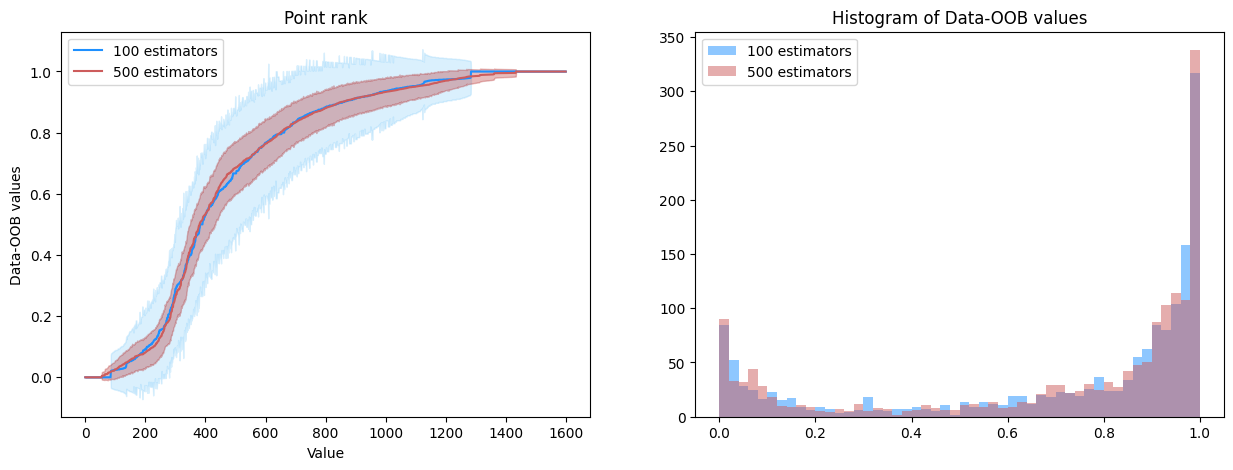

In [6]:
mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for (n_est, values, mean_color, shade_color) in zip(
    n_estimators, oob_values, mean_colors, shade_colors
):
    values.sort(key="value")
    plot_values_ci(
        values,
        level=0.01,
        mean_color=mean_color,
        shade_color=shade_color,
        ax=ax1,
        label=f"{n_est} estimators",
    )

    ax2.hist(values, bins=50, color=mean_color, alpha=0.5, label=f"{n_est} estimators")
ax1.set_title("Point rank")
ax1.set_xlabel("Value")
ax1.set_ylabel("Data-OOB values")
ax1.legend()
ax2.set_title("Histogram of Data-OOB values")
ax2.legend()
plt.plot();

## Point removal experiments

The standard procedure for the evaluation of data valuation schemes is the point removal experiment. The objective is to measure the evolution of performance when the best/worst points are removed from the training set. This can be done with the function [compute_removal_score][pydvl.reporting.scores.compute_removal_score], which takes precomputed values and computes the performance of the model as points are removed.

In [7]:
def removal_job(
    method: Literal["random", "oob"], n_est: int = 300, max_samples: float = 0.95
):
    if method == "random":
        values = ValuationResult.from_random(size=len(utility.data))
    else:
        values = compute_data_oob(
            u=utility, n_est=n_est, max_samples=max_samples, progress=False
        )

    best_scores = compute_removal_score(
        u=utility,
        values=values,
        percentages=removal_percentages,
        remove_best=True,
    )
    best_scores["method_name"] = values.algorithm

    worst_scores = compute_removal_score(
        u=utility,
        values=values,
        percentages=removal_percentages,
        remove_best=False,
    )
    worst_scores["method_name"] = values.algorithm

    return best_scores, worst_scores

In [8]:
n_runs = 20
max_workers = 24

all_best_scores = []
all_worst_scores = []
removal_percentages = np.arange(0, 0.99, 0.01)

pending = set()

with init_executor(max_workers=max_workers) as executor:
    for i in range(n_runs):
        pending.add(executor.submit(removal_job, method="random"))
        pending.add(executor.submit(removal_job, method="data_oob"))

    pbar = tqdm(total=2 * n_runs, unit="%")
    while len(pending) > 0:
        pbar.n = 2 * n_runs - len(pending) + 1  # HACK
        pbar.refresh()
        completed, pending = wait(pending, timeout=0.5, return_when=FIRST_COMPLETED)
        for future in completed:
            best_scores, worst_scores = future.result()
            all_best_scores.append(best_scores)
            all_worst_scores.append(worst_scores)

best_scores_df = pd.DataFrame(all_best_scores)
worst_scores_df = pd.DataFrame(all_worst_scores)

  0%|          | 0/40 [00:00<?, ?%/s]

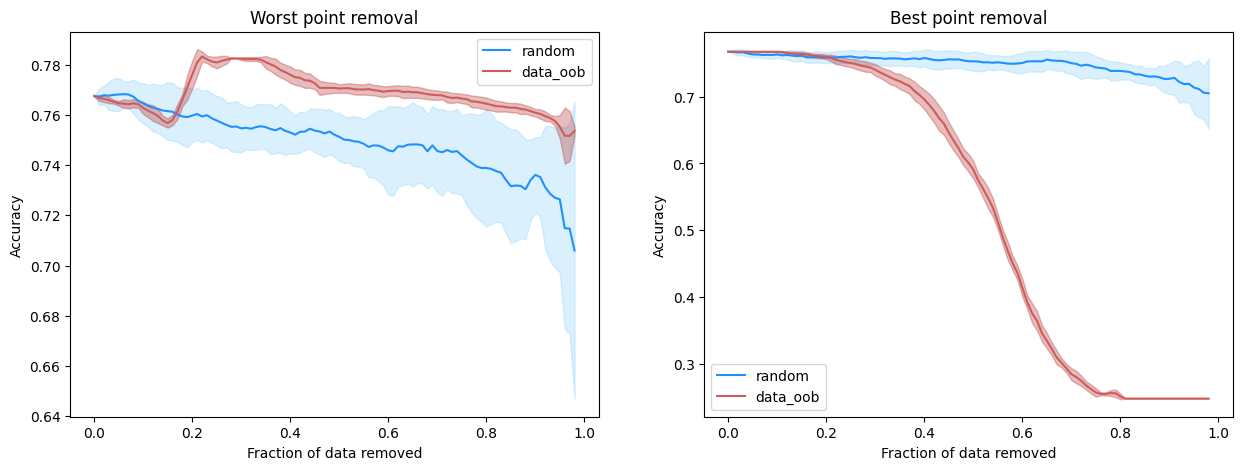

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for i, method_name in enumerate(["random", "data_oob"]):
    metric_name = utility.scorer._name.capitalize()
    shaded_mean_std(
        worst_scores_df[worst_scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Fraction of data removed",
        ylabel=metric_name,
        label=method_name,
        title="Worst point removal",
        ax=ax[0],
    )
    shaded_mean_std(
        best_scores_df[best_scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Fraction of data removed",
        ylabel=metric_name,
        label=method_name,
        title="Best point removal",
        ax=ax[1],
    )
ax[0].legend()
ax[1].legend()
plt.show();